In [ ]:
!pip install gower
!pip install kneed
!pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395101 sha256=c9213e0444f264842b6ea87fcd41fef325b21b7de4f100c322d43c0fa4164e2f
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [ ]:
#Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import h5py
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind, f_oneway
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import gower
from kneed import KneeLocator
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict


In [ ]:
#Se lee el archivo con las imágenes a procesar
df=pd.read_csv('df_final.csv')
df.rename(columns={df.columns[0]: 'isic_id'}, inplace=True)
df.rename(columns={'0': 'imagen'}, inplace=True)
df.head()

,isic_id,imagen,image_size,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0077575,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"(125, 125)",0,IP_4899312,40.0,female,posterior torso,8.44,TBP tile: close-up,...,IL_5505434,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,89.553225
1,ISIC_0077628,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"(119, 119)",0,IP_1039996,40.0,male,posterior torso,10.36,TBP tile: close-up,...,IL_4191716,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.964142
2,ISIC_0078312,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"(143, 143)",0,IP_2939024,65.0,male,posterior torso,5.89,TBP tile: close-up,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.938798
3,ISIC_0078776,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"(115, 115)",0,IP_5989034,45.0,male,posterior torso,3.01,TBP tile: close-up,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
4,ISIC_0080458,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"(105, 105)",0,IP_8172184,75.0,male,posterior torso,3.77,TBP tile: close-up,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,60.297260


Se va a generar un DF con los pixeles de cada imágen. Para esto se van a seguir los siguientes pasos:

1.   Estandarizar el tamaño de todas las imágenes a 120x120
2.   Cambiar a escala de grises
3.   Agregar a un data frame donde cada imagen es una fila y cada pixel una columna, para un total de 14.400 columnas (120x120)



In [ ]:
#Función para normalizar la imagen
def process_image(image_str):
    # Remover el prefijo 'b' y las comillas iniciales/finales si existen
    image_bytes = bytes(image_str[2:], 'utf-8').decode('unicode_escape').encode('ISO-8859-1')
    # Abrir la imagen desde los bytes
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(image, (120, 120))  # Redimensionar a 120x120
    return img_resized.flatten()  # Aplanar la imagen para convertirla en una fila
# Lista para almacenar los datos de píxeles
pixel_data = []
# Recorrer el DataFrame original
for index, row in df.iterrows():
    processed_image = process_image(row['imagen'])
    pixel_data.append(processed_image)  # Agregar la fila procesada a la lista
# Crear el DataFrame a partir de la lista
df_pixel = pd.DataFrame(pixel_data)
# Agregar la columna isic_id
df_pixel['isic_id'] = df['isic_id'].values  # Usar .values para evitar problemas de indexado
df_pixel.to_csv('df_pixel.csv', index=False)
df_pixel.head()

,0,1,2,3,4,5,6,7,8,9,...,14391,14392,14393,14394,14395,14396,14397,14398,14399,isic_id
0,213,213,213,214,215,213,210,210,213,209,...,29,28,26,27,28,30,32,32,29,ISIC_0077575
1,176,175,173,170,168,168,172,175,170,173,...,169,168,170,168,168,172,177,179,176,ISIC_0077628
2,103,100,104,104,96,96,104,103,103,104,...,115,116,117,116,117,118,118,118,117,ISIC_0078312
3,180,174,169,169,173,178,179,177,181,183,...,173,173,173,173,173,173,171,169,166,ISIC_0078776
4,180,186,190,191,187,181,175,174,176,184,...,171,168,170,173,178,180,181,182,189,ISIC_0080458


In [ ]:
#df_pixel=pd.read_csv('df_pixel.csv')
df_pixel=pd.read_csv('df_pixel.csv')
print(df_pixel.shape)
df_pixel.head()

(4596, 14401)


,0,1,2,3,4,5,6,7,8,9,...,14391,14392,14393,14394,14395,14396,14397,14398,14399,isic_id
0,213,213,213,214,215,213,210,210,213,209,...,29,28,26,27,28,30,32,32,29,ISIC_0077575
1,176,175,173,170,168,168,172,175,170,173,...,169,168,170,168,168,172,177,179,176,ISIC_0077628
2,103,100,104,104,96,96,104,103,103,104,...,115,116,117,116,117,118,118,118,117,ISIC_0078312
3,180,174,169,169,173,178,179,177,181,183,...,173,173,173,173,173,173,171,169,166,ISIC_0078776
4,180,186,190,191,187,181,175,174,176,184,...,171,168,170,173,178,180,181,182,189,ISIC_0080458


El costo computacional de esta transformación es alto. Se generó un DF con una dimensión 4596x14401, includido el identificador de cada caso médico

## **Reducción de la dimensionalidad**

Teniendo en cuenta el tamaño del DF, se va a aplicar PCA para encontrar los componentes principales de todas las imágenes. Se parametriza el modelo para que retenga los componentes que explican el 95% de la varianza

In [ ]:
# Eliminar la columna 'isic_id' para aplicar PCA
X = df_pixel.drop('isic_id', axis=1)
# Se estandarizan los datos
X_scaled = StandardScaler().fit_transform(X)
# Inicializar PCA con el número de componentes deseados
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
# Ajustar y transformar los datos
principalComponents = pca.fit_transform(X_scaled)
# Crear un nuevo DataFrame con los componentes principales
principalDf = pd.DataFrame(data = principalComponents)
# Agregar la columna 'isic_id' al DataFrame con los componentes principales
principalDf['isic_id'] = df_pixel['isic_id']
# Mostrar las primeras filas del DataFrame con los componentes principales
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,isic_id
0,58.168640,135.153822,-93.647019,106.947285,-27.194125,53.413679,18.708388,-29.539784,35.427322,-9.822142,...,16.803011,-37.921886,-7.759144,6.439845,8.283257,-2.707009,-12.077360,-10.447955,17.694551,ISIC_0077575
1,-4.343872,-2.323080,1.468923,23.310702,-4.727755,-21.164763,5.288693,-7.284971,5.418358,-9.773494,...,-1.200449,-6.832229,7.104100,1.599185,-1.594660,-4.087147,1.206846,-3.455113,-0.783272,ISIC_0077628
2,171.767487,-9.677187,-21.737358,-0.377637,0.778290,-4.611870,-0.886853,-2.632249,4.249094,-2.129353,...,-0.491006,0.773523,2.921125,-0.929834,-0.371517,-1.200047,1.236291,-3.045719,0.806736,ISIC_0078312
3,-36.705597,2.432923,-0.406778,-3.092080,0.232809,-1.208347,-2.803638,4.205876,-3.702689,5.003011,...,1.466395,-1.216436,1.742409,1.376459,-1.061776,-1.106020,1.268512,1.666323,2.061678,ISIC_0078776
4,-44.804893,-3.976560,-4.193119,2.320333,-2.677761,-0.077938,-1.407674,5.957346,-0.055569,1.725713,...,3.551681,-0.479242,4.228108,-0.227849,1.276071,-0.520953,0.803670,-0.406148,1.267375,ISIC_0080458


Con 25 componentes se explica el 95% de la varianza, lo cual es muy poderoso pues se pasó de tener una matriz de 14.400 columnas a una de 25.

Esto se explica porque las imágenes son homogéneas, la mayoría de ellas tienen dos áreas: piel sana y piel con lesión, la cual normalmente está centrada en la fotografía, por lo que hay muchos píxeles son "constantes" y se pueden reducir.

In [ ]:
#Se exporta el archivo a un csv
#principalDf.to_csv('principalDf.csv', index=False)
principalDf=pd.read_csv('principalDf.csv')
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,isic_id
0,58.168640,135.153822,-93.647019,106.947285,-27.194125,53.413679,18.708388,-29.539784,35.427322,-9.822142,...,16.803011,-37.921886,-7.759144,6.439845,8.283257,-2.707009,-12.077360,-10.447955,17.694551,ISIC_0077575
1,-4.343872,-2.323080,1.468923,23.310702,-4.727755,-21.164763,5.288693,-7.284971,5.418358,-9.773494,...,-1.200449,-6.832229,7.104100,1.599185,-1.594660,-4.087147,1.206846,-3.455113,-0.783272,ISIC_0077628
2,171.767487,-9.677187,-21.737358,-0.377637,0.778290,-4.611870,-0.886853,-2.632249,4.249094,-2.129353,...,-0.491006,0.773523,2.921125,-0.929834,-0.371517,-1.200047,1.236291,-3.045719,0.806736,ISIC_0078312
3,-36.705597,2.432923,-0.406778,-3.092080,0.232809,-1.208347,-2.803638,4.205876,-3.702689,5.003011,...,1.466395,-1.216436,1.742409,1.376459,-1.061776,-1.106020,1.268512,1.666323,2.061678,ISIC_0078776
4,-44.804893,-3.976560,-4.193119,2.320333,-2.677761,-0.077938,-1.407674,5.957346,-0.055569,1.725713,...,3.551681,-0.479242,4.228108,-0.227849,1.276071,-0.520953,0.803670,-0.406148,1.267375,ISIC_0080458


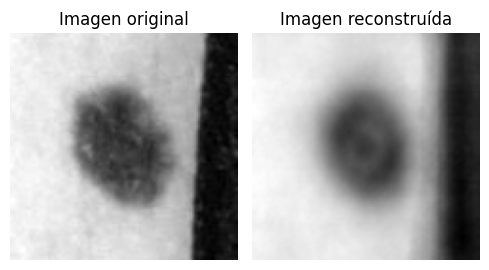

In [ ]:
#Se va a dibujar la primera imagen para comparar el impacto por reducir la dimensionalidad
#Imagen original
row_df_pixel = df_pixel.iloc[0]
pixels = row_df_pixel.drop('isic_id')
pixels=pixels.astype(np.uint8)
img_reconstructed = pixels.values.reshape(120, 120)

#Imagen reconstruída
row_principalDf = principalDf.iloc[0]
# Obtener los componentes principales de la imagen
principal_components = row_principalDf.drop('isic_id')
# Reconstruir la imagen utilizando los componentes principales y la transformación inversa de PCA
reconstructed_image_scaled = pca.inverse_transform([principal_components])
scaler = StandardScaler()
scaler.fit(X)
reconstructed_image = scaler.inverse_transform(reconstructed_image_scaled)
img_reconstructed2 = reconstructed_image.reshape(120, 120)

# Mostrar la imagen
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('Imagen original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_reconstructed2, cmap='gray')
plt.title('Imagen reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()


La precisión de la imagen de la derecha se debe evaluar dependiendo del objetivo del análisis. Para el caso que nos ocupa, el cual es la identificación del área afectada, la precisión es aceptable porque la zona con la lesión ocupa un número similar de píxeles, inclusive detalles en el interior de la lesión.

Sin lugar a dudas, para otros objetivos, como diagnóstico médico, modelos de predicción, entre otros, la perdida de información puede ser inaceptable.

### **Clúster jerárquico**

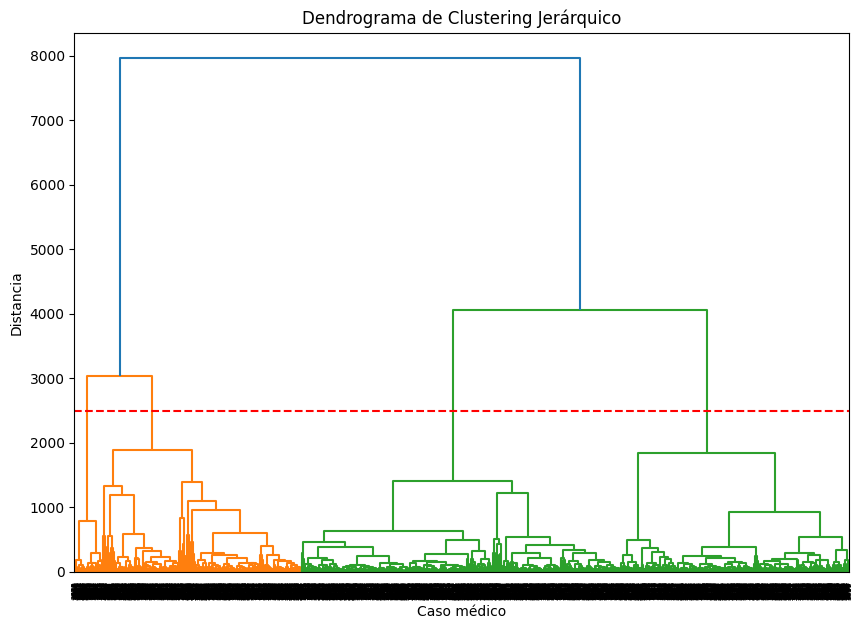

In [ ]:
# Realizar el clustering jerárquico utilizando el enlace 'ward' y distancia euclidiana
Z = linkage(principalDf.drop('isic_id', axis=1), method='ward', metric='euclidean')

# Graficar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.axhline(y=2500, color='r', linestyle='--')  # Línea para fijar la distancia en 2500
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Caso médico')
plt.ylabel('Distancia')
plt.show()

Se identifican 4 grandes clústeres los cuales pueden significar 4 tipos de lesión cutánea.

In [ ]:
# Identificar el número de clusters fijando una distancia de corte de 6
clusters = fcluster(Z, t=2500, criterion='distance')

# Agregar los clusters al DataFrame
principalDf['Cluster_Jerarquico'] = clusters

# Mostrar el número de clusters encontrados y su conteo
print(f"Número de clusters formados: {len(set(clusters))}")
print(principalDf['Cluster_Jerarquico'].value_counts())

Número de clusters formados: 4
Cluster_Jerarquico
3    1890
4    1356
2    1184
1     166
Name: count, dtype: int64


Los clústeres 2, 3 y 4 tienen una población similar, siendo el número 3 el que más casos agrupa. El cluster 1 solo agrupa un 3% DE la población total, lo cual amerita un análisis más profundo para estudiar las características de este cluster.

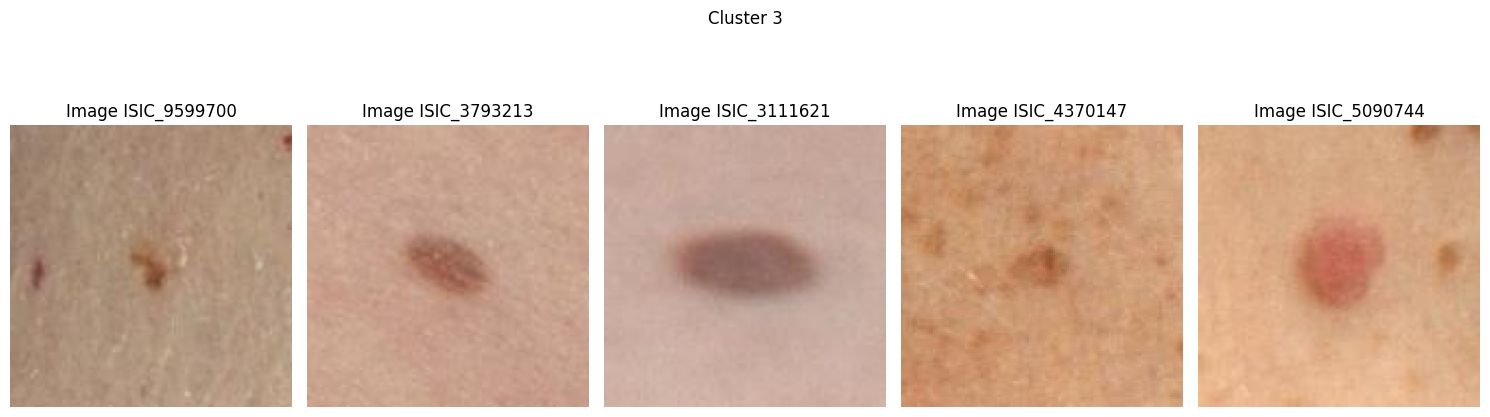

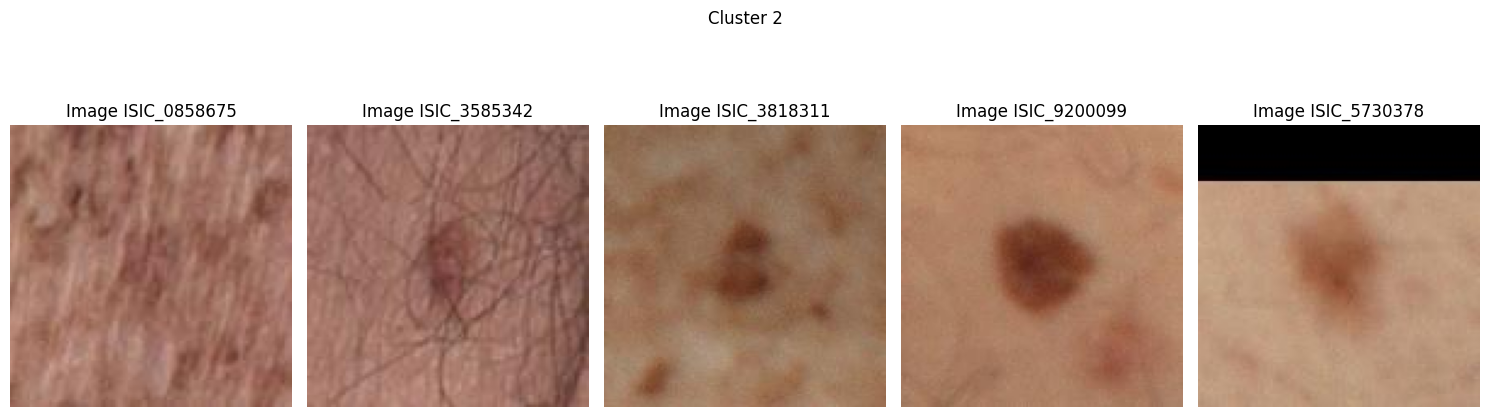

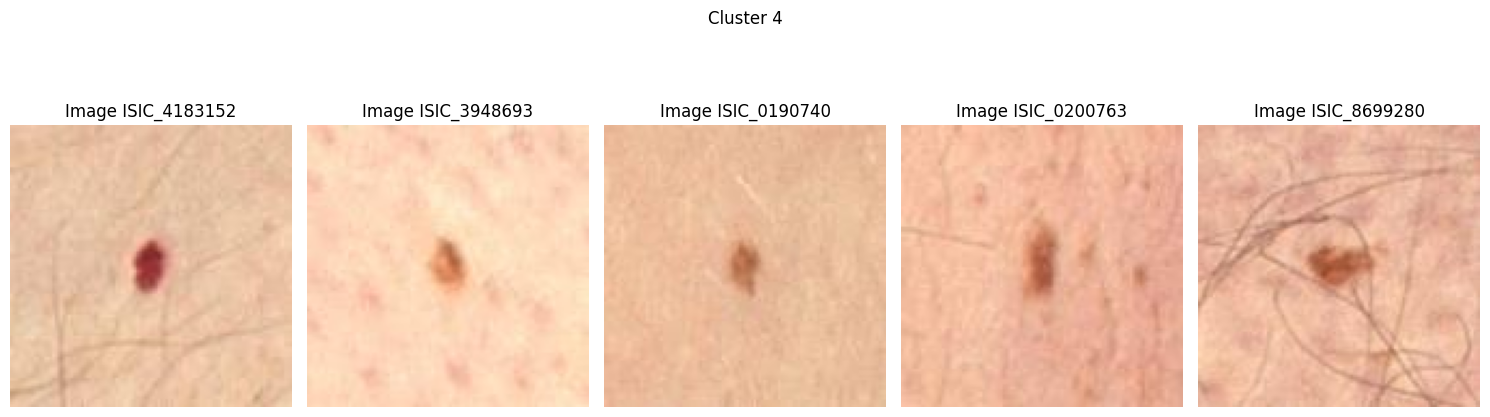

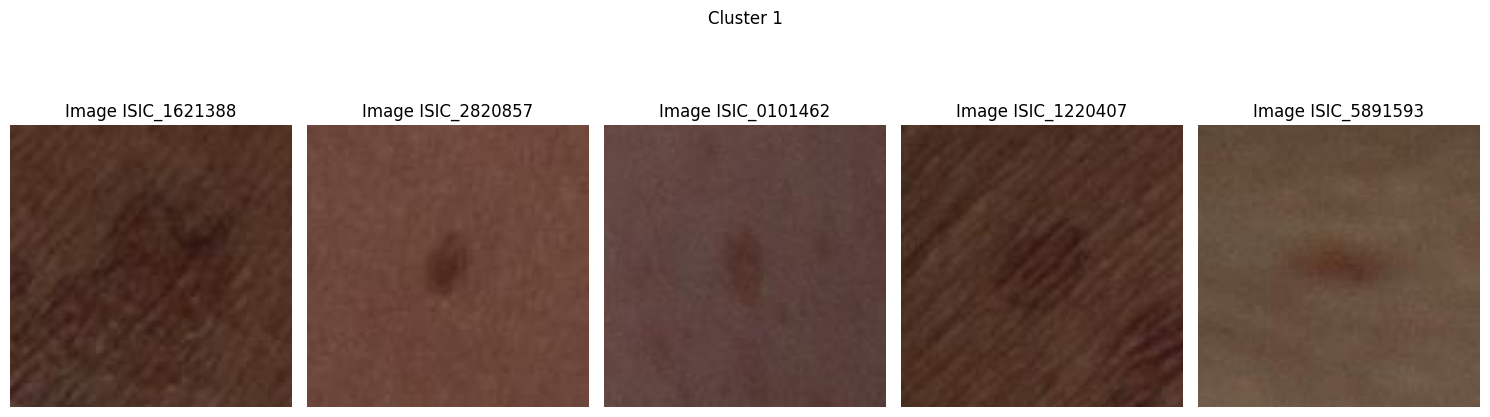

In [ ]:
#Se van a dibujar 5 imágenes de cada cluster para ver que similitudes comparten
for cluster_id in principalDf['Cluster_Jerarquico'].unique():
  cluster_df = principalDf[principalDf['Cluster_Jerarquico'] == cluster_id]
  sample_isic_ids = cluster_df.sample(n=min(5, len(cluster_df)))['isic_id'].tolist()
  plt.figure(figsize=(15, 5))
  plt.suptitle(f'Cluster {cluster_id}')
  for i, isic_id in enumerate(sample_isic_ids):
    row = df[df['isic_id'] == isic_id].iloc[0]
    image_str = row['imagen']
    # Remover el prefijo 'b' y las comillas iniciales/finales si existen
    image_bytes = bytes(image_str[2:], 'utf-8').decode('unicode_escape').encode('ISO-8859-1')
    # Abrir la imagen desde los bytes
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    plt.subplot(1, len(sample_isic_ids), i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f'Image {isic_id}')
    plt.axis('off')
  plt.tight_layout()
  plt.show()


Desde el punto de vista visual, cada cluster tiene ciertas características:

1. Cluster 1: Los tonos de piel son más oscuros y la anomalía de la piel no es tan marcada. La calidad de las imágenes es menor y seguramente esto podría ser un criterio para descartar imágenes que no se pueden analizar.
2. Cluster 2: Se caracteriza porque tiene varias lesiones en la piel y el área afectada es mucho más grande que los otros clústeres.
3. Cluster 3: Se caracteriza por tono de piel clara y el área afectada se resalta fuertemente; adicionalmente se las lesiones tienen una orientación horizontal
4. Cluster 4: Es similar al clúster 3 pero la orientación de la lesión es vertical

Esta agrupación es conveniente para una primera clasificación de las imágenes. Para propósitos más avanzados de estudio, se deberá validar por el personal experto, si las condiciones antes descritas son características relevantes en el diagnóstico

In [ ]:
#Se adicionan las columnas 'sex', 'age_approx' y 'target' ald dataframe
principalDf = pd.merge(principalDf, df[['isic_id', 'sex', 'age_approx', 'target']], on='isic_id', how='left')
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,isic_id,sex,age_approx,target,Cluster_Jerarquico
0,58.168640,135.153822,-93.647019,106.947285,-27.194125,53.413679,18.708388,-29.539784,35.427322,-9.822142,...,8.283257,-2.707009,-12.077360,-10.447955,17.694551,ISIC_0077575,female,40.0,0,3
1,-4.343872,-2.323080,1.468923,23.310702,-4.727755,-21.164763,5.288693,-7.284971,5.418358,-9.773494,...,-1.594660,-4.087147,1.206846,-3.455113,-0.783272,ISIC_0077628,male,40.0,0,3
2,171.767487,-9.677187,-21.737358,-0.377637,0.778290,-4.611870,-0.886853,-2.632249,4.249094,-2.129353,...,-0.371517,-1.200047,1.236291,-3.045719,0.806736,ISIC_0078312,male,65.0,0,2
3,-36.705597,2.432923,-0.406778,-3.092080,0.232809,-1.208347,-2.803638,4.205876,-3.702689,5.003011,...,-1.061776,-1.106020,1.268512,1.666323,2.061678,ISIC_0078776,male,45.0,0,3
4,-44.804893,-3.976560,-4.193119,2.320333,-2.677761,-0.077938,-1.407674,5.957346,-0.055569,1.725713,...,1.276071,-0.520953,0.803670,-0.406148,1.267375,ISIC_0080458,male,75.0,0,3


## **Algoritmo Jerárquico Aglomerativo**

In [ ]:
# Descripción de los clusters encontrados por edad
cluster_summary = principalDf.groupby('Cluster_Jerarquico').agg({
    'age_approx': ['mean', 'std']})
cluster_summary

age_approx           
                         mean        std
Cluster_Jerarquico                      
1                   58.253012  14.087040
2                   55.560272  15.502904
3                   52.315258  14.038171
4                   53.233111  13.862110

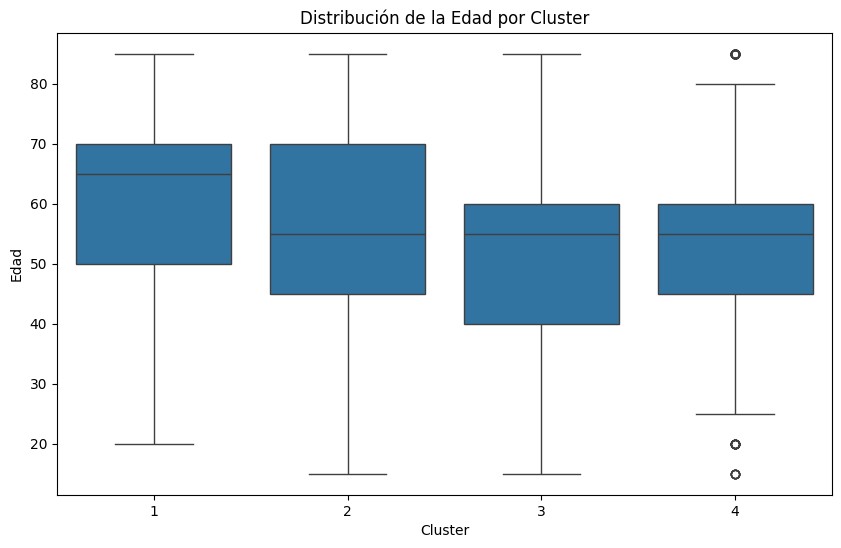

In [ ]:
#Box plot de las edades para cada cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_Jerarquico', y='age_approx', data=principalDf)
plt.title('Distribución de la Edad por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Edad')
plt.show()


Los grupos tienen rangos similares de edades. El clúster uno tiene un promedio más elevado que el resto de clúster

In [ ]:
# Descripción de los clusters encontrados
cluster_summary = principalDf.groupby('Cluster_Jerarquico').agg({
    'sex': 'value_counts'})
cluster_summary

sex
Cluster_Jerarquico sex         
1                  male     127
                   female    36
2                  male     796
                   female   372
3                  male    1054
                   female   814
4                  female   734
                   male     604

Los clústeres 3 y 4 tienen una distribución similar a la muetra total, donde hombres tiene una participación cercana al 60% y el resto mujeres. Los clústeres 1 y 2 agrupan lesiones que se presentan más en hombres que en mujeres, con una relación 2:1 y 3:1 respectivamente

In [ ]:
# Descripción de los clusters encontrados por casos positivos de cancer
cluster_summary = principalDf.groupby('Cluster_Jerarquico').agg({
    'target': 'value_counts'})
cluster_summary

target
Cluster_Jerarquico target        
1                  0          166
2                  0         1181
                   1            3
3                  0         1889
                   1            1
4                  0         1356

Las lesiones de los clústeres 1 y 4 no registran casos positivos, se debe investigar más si las características de estos grupos permiten concluir cuando un caso es benigno. Los clústeres 2 y 3 registran casos positivos. Se resalta la concentración en el cluster  pues el porcentaje asciende al 0.25% mientra que la muestra total está en el 0.1%

# **Detección de áreas afectadas mediante clustering**

Uno de los primeros pasos para la detección temprana de lesiones cutáneas es la identificación del área afectada. Se van a utilizar dos técnicas para marcar en las fotografías las áreas con alguna lesión, así:

1. Teniendo en cuenta que la mayoría de lesiones tienen un área de 8 mm2, se va a recorrer la imagen seleccionada con cuadrículas de 25x25 píxeles con un paso de 5 píxeles tanto horizontal como vertical y se va a marcar el área cuyo promedio sea más oscuro.

2. Utilizando el algoritmo de KMedoides se va a encontrar dos cluster en cada imagen: piel sana y piel con lesión. Para esto se va aplicar la misma técnica de recorrer la imagen seleccionada y se van a generar 400 cuadrículas de 25x25 (625 píxeles) para que el algoritmo encuentre las cuadrículas disímiles y se puedan etiquetar los píxeles que posiblemente tienen una lesión cutánea.

## **Marcación del área afectada por el promedio**

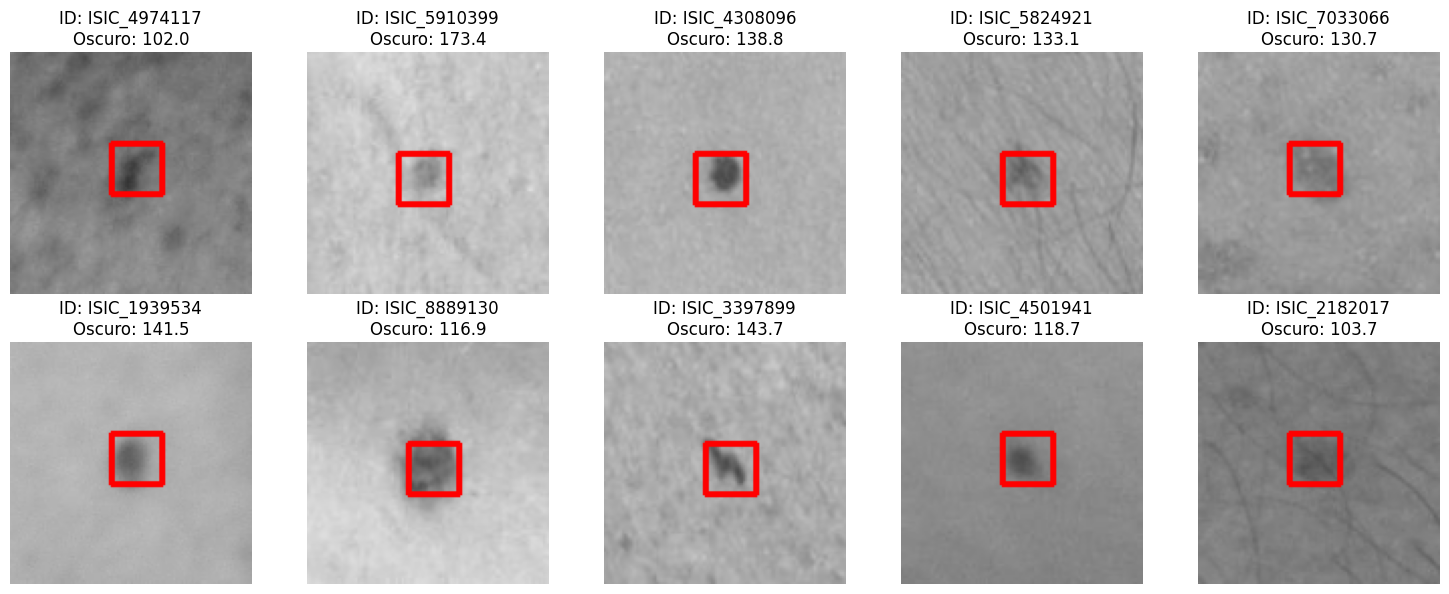

In [ ]:
# Definir el tamaño de la cuadrícula y el paso
tam_cuadricula = 25
paso = 5

#Se genera una muestra de 10 imágenes
sample_images = df_pixel.sample(n=min(10, len(df_pixel)))['isic_id'].tolist()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for idx, isic_id in enumerate(sample_images):
    row = df_pixel[df_pixel['isic_id'] == isic_id]
    row = row.drop('isic_id', axis=1)
    image = row.values.reshape(120, 120)
    image = image.astype(np.uint8)
    # Inicializar variables para almacenar la mejor cuadrícula y su valor medio
    mejor_promedio_oscuro = 255
    mejor_cuadro_oscuro = None
    mejor_coordenadas_oscuro = (0, 0)
    # Recorrer la imagen en bloques de 25x25 píxeles con pasos de 5 píxeles
    for y in range(0, image.shape[0] - tam_cuadricula+1, paso):
        for x in range(0, image.shape[1] - tam_cuadricula+1, paso):
            cuadro = image[y:y + tam_cuadricula, x:x + tam_cuadricula]
            promedio = np.mean(cuadro)
            # Actualizar el cuadro más oscuro
            if promedio < mejor_promedio_oscuro:
                mejor_promedio_oscuro = promedio
                mejor_cuadro_oscuro = cuadro
                mejor_coordenadas_oscuro = (x, y)
    # Dibujar rectángulos alrededor de las mejores cuadrículas en la imagen original
    imagen_con_cuadros = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convertir a color para dibujar rectángulos
    cv2.rectangle(imagen_con_cuadros, mejor_coordenadas_oscuro,
                  (mejor_coordenadas_oscuro[0] + tam_cuadricula, mejor_coordenadas_oscuro[1] + tam_cuadricula),
                  (255, 0, 0), 2)  # Azul para el cuadro más oscuro
    # Mostrar la imagen en la cuadrícula
    axes[idx].imshow(imagen_con_cuadros, cmap='gray')
    axes[idx].set_title(f"ID: {isic_id}\nOscuro: {mejor_promedio_oscuro:.1f}")
    axes[idx].axis('off')

# Mostrar todas las imágenes en la cuadrícula 2x5
plt.tight_layout()
plt.show()

Se puede ver que esta técnica demarca el área afectada con un buen nivel de precisión, no obstante solo se marca el área que más difiere del resto y una imagen puede contener varias lesiones.

Con este procedimiento, se puede extraer el área de la lesión unicamente y se pueden desarrollar algoritmos de predicción que se entrenen con muestras más específicas.

## **Marcación con clustering**

Número de clusters formados: 2
Cluster_K_Medoides
1    374
0     26
Name: count, dtype: int64


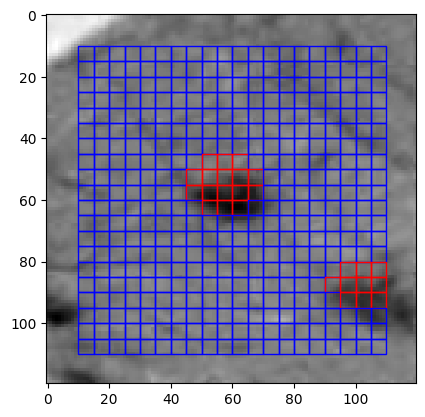

In [ ]:
# Definición de la cuadrícula y el paso
tam_cuadricula = 25
paso = 5
#Se selecciona la imagen 20 por tener dos lesiones cutáneas
row = df_pixel.iloc[20]
row = row.drop('isic_id')
image = row.values.reshape(120, 120)
#Se recorre la imagen en bloques de 25x25 con paso de 5
lista_bloques = []
for y in range(0, image.shape[0] - tam_cuadricula + 1, paso):
    for x in range(0, image.shape[1] - tam_cuadricula + 1, paso):
        # Extraer la cuadrícula actual de 25x25
        cuadro = image[y:y + tam_cuadricula, x:x + tam_cuadricula]
        # Aplanar el bloque de 25x25 y agregarlo a la lista
        lista_bloques.append(cuadro.flatten())

# Crear un DataFrame a partir de los bloques extraídos
df_cuadriculas = pd.DataFrame(lista_bloques)
# Estandarizar los datos
scaler = MinMaxScaler()
df_cuadriculas_scaled = scaler.fit_transform(df_cuadriculas)
# Inicializar los índices de los medoids aleatorios
num_clusters = 2
initial_medoids = np.random.choice(df_cuadriculas_scaled.shape[0], num_clusters, replace=False)
# Implementar K-Medoides
kmedoids_instance = kmedoids(df_cuadriculas_scaled, initial_medoids)
kmedoids_instance.process()
clusters_kmedoids = kmedoids_instance.get_clusters()

# Añadir los resultados de los clusters al DataFrame
df_cuadriculas['Cluster_K_Medoides'] = -1  # Inicializa con -1 (no asignado)
for cluster_id, indices in enumerate(clusters_kmedoids):
    df_cuadriculas.loc[indices, 'Cluster_K_Medoides'] = cluster_id

# Mostrar la distribución de los clusters
print(f"Número de clusters formados: {num_clusters}")
print(df_cuadriculas['Cluster_K_Medoides'].value_counts())

image = image.astype(np.float32)
# Asignar un color a cada cluster
colores = {0: 'red', 1: 'blue'}
plt.imshow(image, cmap='gray')
frecuencia_clusters = {}
# Dibujar los bloques en el color correspondiente al cluster más frecuente
for idx, (y, x) in enumerate([(y, x) for y in range(0, image.shape[0] - tam_cuadricula + 1, paso)
                                 for x in range(0, image.shape[1] - tam_cuadricula + 1, paso)]):
    cluster = df_cuadriculas['Cluster_K_Medoides'].iloc[idx]
    # Si el bloque ya está en el diccionario, se incrementa el contador
    if (y, x) not in frecuencia_clusters:
        frecuencia_clusters[(y, x)] = {}
    if cluster not in frecuencia_clusters[(y, x)]:
        frecuencia_clusters[(y, x)][cluster] = 0
    frecuencia_clusters[(y, x)][cluster] += 1

# Para cada bloque se encuentra el cluster más frecuente
for (y, x), clusters in frecuencia_clusters.items():
    cluster_mas_frecuente = max(clusters, key=clusters.get)
    plt.gca().add_patch(plt.Rectangle((x+10, y+10), 5, 5, edgecolor=colores[cluster_mas_frecuente], facecolor='none', linewidth=1))
plt.show()

Con esta técnica se encontraron dos áreas con posible lesión. No obstante, este algoritmo es susceptible a la sintonización de varios Hiperparámetros y el resultado se afecta por el ajuste de estos, por lo que no es muy recomendamble.